In [10]:
import os
import cv2
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from collections import defaultdict
import random

In [5]:
# Paths
images_dir = "data/train/images"
labels_dir = "data/train/labels"

# Class mapping
class_map = {
    0: 'dog',
    1: 'cat',
    2: 'cow',
    3: 'goat',
    4: 'boar',
    5: 'deer',
    6: 'leopard'
}

In [6]:
image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.jpg') or f.endswith('.png')])
label_files = sorted([f for f in os.listdir(labels_dir) if f.endswith('.txt')])

print(f'Total images: {len(image_files)}')
print(f'Total label files: {len(label_files)}')

Total images: 513
Total label files: 513


dog - 78
cat - 74
cow - 594
goat - 162
boar - 102
deer - 174
leopard - 74


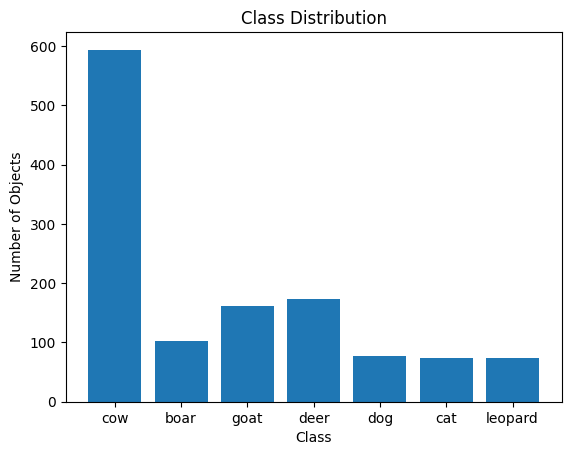

In [7]:
all_classes = []
for label_file in label_files:
    if label_file != "classes.txt":
        with open(os.path.join(labels_dir, label_file)) as f:
            for line in f:
                class_idx = int(line.split()[0])
                all_classes.append(class_idx)

class_counts = Counter(all_classes)

#print all object counts
for class_idx in sorted(class_counts):
    class_name = class_map.get(class_idx, str(class_idx))
    print(f"{class_name} - {class_counts[class_idx]}")

#plot object counts 
plt.bar([class_map[c] for c in class_counts.keys()], class_counts.values())
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Objects')
plt.show()

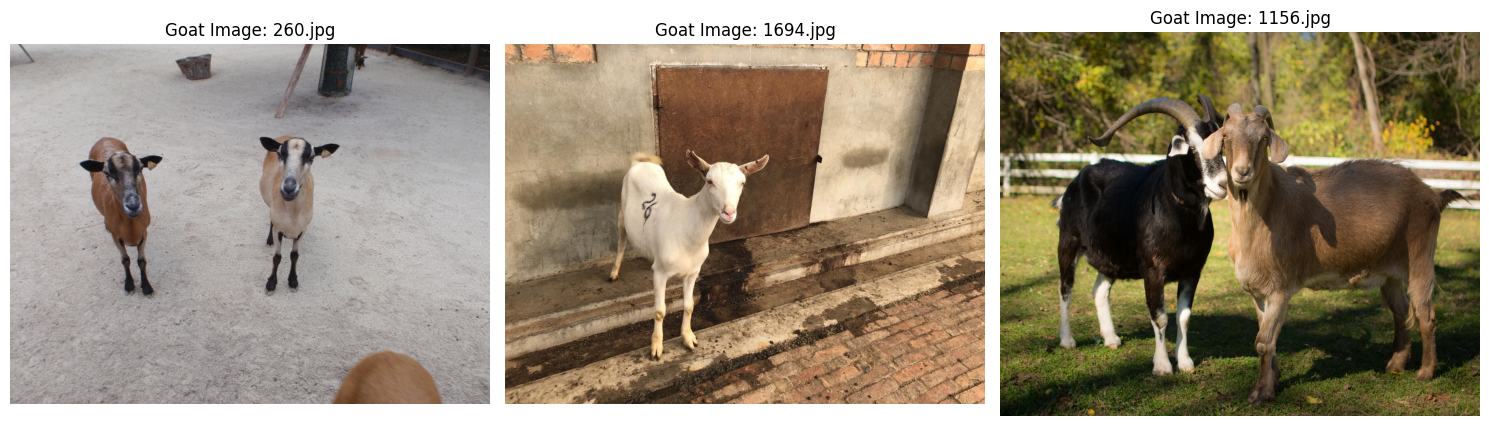

In [24]:
NUM_IMAGES = 3 
TARGET_CLASS = 3   # 3 is target class for goat
def get_goat_images():
    """Identify images containing goats"""
    goat_images = []
    for img_file in os.listdir(images_dir):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            base_name = os.path.splitext(img_file)[0]
            label_path = os.path.join(labels_dir, f"{base_name}.txt")
            
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    for line in f:
                        if line.strip() and int(line.split()[0]) == TARGET_CLASS:
                            goat_images.append(img_file)
                            break
    return goat_images

def display_images(image_paths):
    """Display images in a grid"""
    plt.figure(figsize=(15, 10))
    class_name = class_map.get(TARGET_CLASS, 'Unknown')
    for i, img_path in enumerate(image_paths, 1):
        img = cv2.imread(os.path.join(images_dir, img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(1, len(image_paths), i)
        plt.imshow(img_rgb)
        plt.title(f"{class_name.capitalize()} Image: {img_path}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Main execution
goat_images = get_goat_images()
selected_images = random.sample(goat_images, min(NUM_IMAGES, len(goat_images)))

if selected_images:
    #print(f"Displaying {len(selected_images)} goat images:")
    display_images(selected_images)
else:
    print("No goat images found in the dataset")

Displaying 3images with large bounding boxes (>0.7 normalized size):


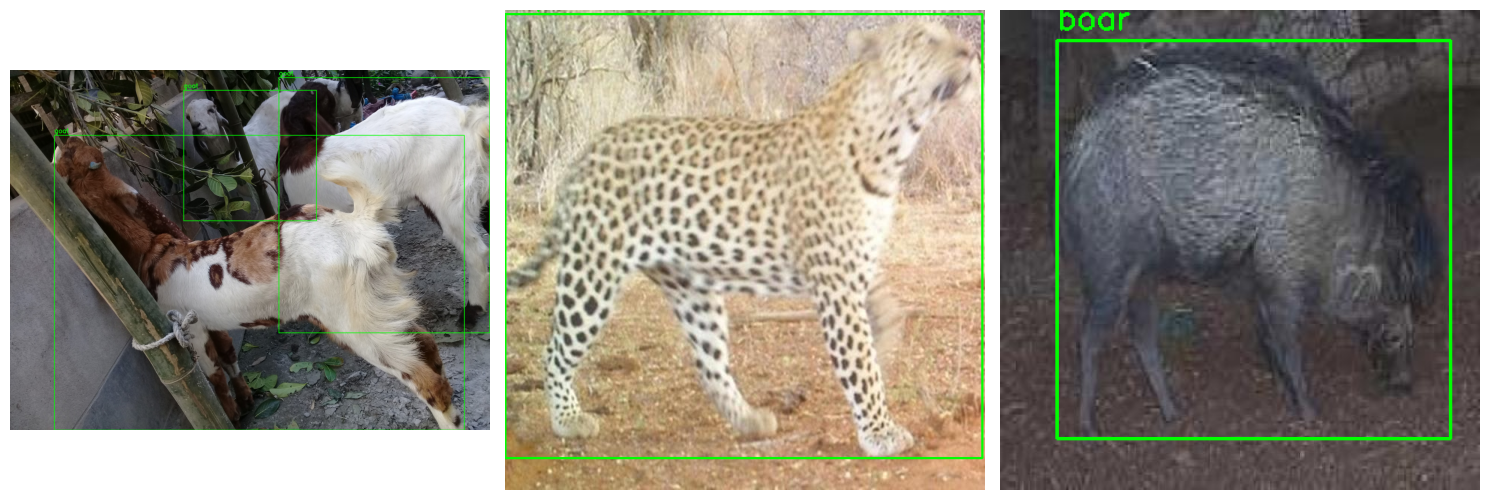

In [35]:
# Configuration
THRESHOLD = 0.7  # Normalized size threshold for width/height
NUM_IMAGES = 3   # Number of images to display

def get_large_bbox_images(threshold):
    """Find images with bounding boxes larger than threshold"""
    large_bbox_images = []
    for img_file in os.listdir(images_dir):
        if img_file.lower().endswith(('.jpg', '.png')):
            base_name = os.path.splitext(img_file)[0]
            label_path = os.path.join(labels_dir, f"{base_name}.txt")
            
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    for line in f:
                        if line.strip():
                            parts = line.split()
                            if len(parts) == 5:  # YOLO format: class x_center y_center width height
                                w = float(parts[3])
                                h = float(parts[4])
                                if w > threshold and h > threshold:
                                    large_bbox_images.append(img_file)
                                    break
    return large_bbox_images

def draw_boxes(image, label_path):
    """Draw bounding boxes and class labels on image"""
    h, w = image.shape[:2]
    with open(label_path, 'r') as f:
        for line in f:
            if line.strip():
                parts = line.split()
                if len(parts) == 5:
                    class_id = int(parts[0])
                    x_center = float(parts[1]) * w
                    y_center = float(parts[2]) * h
                    box_w = float(parts[3]) * w
                    box_h = float(parts[4]) * h
                    
                    # Calculate coordinates
                    x1 = int(x_center - box_w/2)
                    y1 = int(y_center - box_h/2)
                    x2 = int(x_center + box_w/2)
                    y2 = int(y_center + box_h/2)
                    
                    # Draw rectangle
                    color = (0, 255, 0)  # Green
                    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
                    
                    # Draw class label
                    class_name = class_map.get(class_id, 'unknown')
                    cv2.putText(image, class_name, (x1, y1-10), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

def display_images(image_paths):
    """Display images with bounding boxes"""
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(image_paths, 1):
        img = cv2.imread(os.path.join(images_dir, img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Get corresponding label path
        base_name = os.path.splitext(img_path)[0]
        label_path = os.path.join(labels_dir, f"{base_name}.txt")
        
        # Draw bounding boxes
        draw_boxes(img_rgb, label_path)
        
        plt.subplot(1, len(image_paths), i)
        plt.imshow(img_rgb)
        #plt.title(f"Image: {img_path}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Main execution
large_bbox_images = get_large_bbox_images(THRESHOLD)
selected_images = random.sample(large_bbox_images, min(NUM_IMAGES, len(large_bbox_images)))

if selected_images:
    print(f"Displaying {len(selected_images)}images with large bounding boxes (>{THRESHOLD} normalized size):")
    display_images(selected_images)
else:
    print(f"No images found with bounding boxes larger than {THRESHOLD} in normalized size")